In [1]:
import pandas as pd

# Load the training dataset
df = pd.read_csv('train.csv')

# View the first few rows
print(df.head())

# Basic info about the data
print(df.info())

# Checking  for null val
print(df.isnull().sum())


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 co

isFraud
0    6354407
1       8213
Name: count, dtype: int64


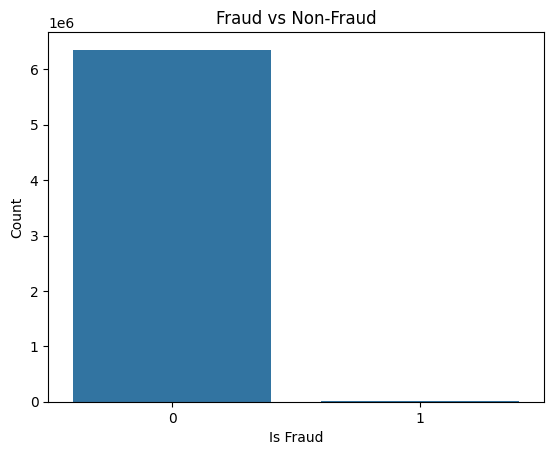

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# counting for  fraud vs non-fraud
print(df['isFraud'].value_counts())

# Plot 
sns.countplot(x='isFraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.xlabel("Is Fraud")
plt.ylabel("Count")
plt.show()


In [3]:
# checking ratio of fraud
fraud_ratio = df['isFraud'].sum() / len(df)
print(f"Fraudulent transactions: {fraud_ratio:.4f} ({fraud_ratio * 100:.2f}%)")

Fraudulent transactions: 0.0013 (0.13%)


In [4]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [5]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [6]:
# Create error features using correct column names
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [7]:
print(df[['errorBalanceOrig', 'errorBalanceDest']].describe())

       errorBalanceOrig  errorBalanceDest
count      6.362620e+06      6.362620e+06
mean      -2.010925e+05     -5.556717e+04
std        6.066505e+05      4.415288e+05
min       -9.244552e+07     -1.319123e+07
25%       -2.496411e+05     -2.935305e+04
50%       -6.867726e+04     -3.500490e+03
75%       -2.954230e+03      0.000000e+00
max        1.000000e-02      7.588573e+07


In [8]:
# Separating features and target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

In [9]:
from sklearn.model_selection import train_test_split

# Spliting into train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])
print("Fraud count in y_train:", sum(y_train))
print("Fraud count in y_test:", sum(y_test))



Training samples: 5090096
Test samples: 1272524
Fraud count in y_train: 6570
Fraud count in y_test: 1643


In [10]:
from imblearn.over_sampling import SMOTE

#  SMOTE to training data only
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print("After SMOTE:")
print("Total training samples:", X_train_smote.shape[0])
print("Fraud count:", sum(y_train_smote))
print("Non-fraud count:", len(y_train_smote) - sum(y_train_smote))

After SMOTE:
Total training samples: 10167052
Fraud count: 5083526
Non-fraud count: 5083526


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#models Logistick Regression and Decision Tree
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [12]:
for name, model in models.items():
    print(f"\n Training: {name}")

    # Training on SMOTE data
    model.fit(X_train_smote, y_train_smote)  
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities  AUC

    print(f"\n Results for {name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.4f}")



 Training: Logistic Regression

 Results for Logistic Regression
Confusion Matrix:
[[1161016  109865]
 [    166    1477]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9136    0.9548   1270881
           1     0.0133    0.8990    0.0261      1643

    accuracy                         0.9135   1272524
   macro avg     0.5066    0.9063    0.4905   1272524
weighted avg     0.9986    0.9135    0.9536   1272524

AUC-ROC Score: 0.9634

 Training: Decision Tree

 Results for Decision Tree
Confusion Matrix:
[[1270778     103]
 [      4    1639]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000   1270881
           1     0.9409    0.9976    0.9684      1643

    accuracy                         0.9999   1272524
   macro avg     0.9704    0.9987    0.9842   1272524
weighted avg     0.9999    0.9999    0.9999   1272524

AUC-ROC Score: 0.9987


In [13]:
# now XG Boost model 

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Init the XGBoost 
xgb = XGBClassifier(
    eval_metric='logloss',       # removed 'use_label_encoder=False' to avoid warning
    random_state=42              
)

# Training the model on the SMOTE balanced training set
xgb.fit(X_train_smote, y_train_smote)

# Making predictions on the test set
y_pred_xgb = xgb.predict(X_test)  
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]  

print(" Confusion Matrix:")

# Showing true vs predicted values
print(confusion_matrix(y_test, y_pred_xgb))  

print("\n Classification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))  

print(f"\n AUC-ROC Score: {roc_auc_score(y_test, y_proba_xgb):.4f}")  


 Confusion Matrix:
[[1270504     377]
 [     16    1627]]

 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9998   1270881
           1     0.8119    0.9903    0.8922      1643

    accuracy                         0.9997   1272524
   macro avg     0.9059    0.9950    0.9460   1272524
weighted avg     0.9997    0.9997    0.9997   1272524


 AUC-ROC Score: 0.9998


In [14]:
# Hyperparameter Tuning using GridSearchCV

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

#  hyperparameter grid 20 combinations
param_grid = {
    'n_estimators': [100, 150],           
    'max_depth': [3, 5, 7, 9],            
    'learning_rate': [0.05, 0.1, 0.2],    
    'subsample': [0.8],                 
    'colsample_bytree': [0.8, 1.0]        
}


#  XGBoost base model with CPU-safe tree method
xgb_base = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    tree_method='hist'  
)

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fitting GridSearchCV
grid_search.fit(X_train_smote, y_train_smote)

# Best model from search
best_xgb = grid_search.best_estimator_

# Predict on test data
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]


print(" Best Parameters:", grid_search.best_params_)
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print("\n Classification Report:")
print(classification_report(y_test, y_pred_best, digits=4))
print(f"\n AUC-ROC Score: {roc_auc_score(y_test, y_proba_best):.4f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits


C:\Users\KARAN\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [22:18:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 150, 'subsample': 0.8}

 Confusion Matrix:
[[1270569     312]
 [     20    1623]]

 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9998    0.9999   1270881
           1     0.8388    0.9878    0.9072      1643

    accuracy                         0.9997   1272524
   macro avg     0.9194    0.9938    0.9535   1272524
weighted avg     0.9998    0.9997    0.9997   1272524


 AUC-ROC Score: 0.9997


In [15]:
import joblib

# Save the best model
joblib.dump(best_xgb, "xgb_fraud_model.pkl")


['xgb_fraud_model.pkl']

In [18]:
# real time prediction function

def predict_fraud(transaction_dict, model):
    import pandas as pd

    # Convert input dictionary to DataFrame
    df = pd.DataFrame([transaction_dict])

    # Predict class and probability
    prediction = model.predict(df)[0]
    probability = model.predict_proba(df)[0][1]

    return {
        "is_fraud": int(prediction),
        "fraud_probability": round(probability, 4)
    }


In [19]:
print(X_train.columns.tolist())


['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER', 'errorBalanceOrig', 'errorBalanceDest']


In [25]:
import joblib

# Load the saved model
model = joblib.load("xgb_fraud_model.pkl")

# Simulate a new real-time transaction (you can change these values to test)
input_raw = {
    'step': 344,
    'amount': 181.0,
    'oldbalanceOrg': 181.0,
    'newbalanceOrig': 0.0,
    'oldbalanceDest': 0.0,
    'newbalanceDest': 0.0,
    'type_CASH_OUT': 0,
    'type_DEBIT': 0,
    'type_PAYMENT': 0,
    'type_TRANSFER': 1
}

# Derived features
input_raw['errorBalanceOrig'] = input_raw['oldbalanceOrg'] - input_raw['newbalanceOrig'] - input_raw['amount']
input_raw['errorBalanceDest'] = input_raw['newbalanceDest'] - input_raw['oldbalanceDest'] - input_raw['amount']

result = predict_fraud(input_raw, model)
print("Real-time Prediction Result:", result)


Real-time Prediction Result: {'is_fraud': 1, 'fraud_probability': 1.0}
